In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from keras.preprocessing import image

import matplotlib.image as mpimg
plt.rcParams.update({'figure.max_open_warning': 0})

In [ ]:
train_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/train/train"
validation_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/validation/validation"
test_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/test/test"

creating data generators

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)  
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/trainingset_v1d1_metadata.csv")
df.label.value_counts()

Blip                   1821
Koi_Fish                706
Low_Frequency_Burst     621
Light_Modulation        512
Power_Line              449
Extremely_Loud          447
Low_Frequency_Lines     447
Scattered_Light         443
Violin_Mode             412
Scratchy                337
1080Lines               328
Whistle                 299
Helix                   279
Repeating_Blips         263
No_Glitch               150
Tomte                   103
1400Ripples              81
None_of_the_Above        81
Chirp                    60
Air_Compressor           58
Wandering_Line           42
Paired_Doves             27
Name: label, dtype: int64

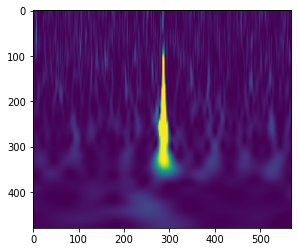

In [ ]:
fullpath = train_dir + "/Blip/" + os.listdir(train_dir + "/Blip")[0]
img = mpimg.imread(fullpath)
plt.imshow(img)

getting the class names

In [ ]:
classes_list = df.label.value_counts().index
classes_list = list(classes_list)
classes_list

['Blip',
 'Koi_Fish',
 'Low_Frequency_Burst',
 'Light_Modulation',
 'Power_Line',
 'Extremely_Loud',
 'Low_Frequency_Lines',
 'Scattered_Light',
 'Violin_Mode',
 'Scratchy',
 '1080Lines',
 'Whistle',
 'Helix',
 'Repeating_Blips',
 'No_Glitch',
 'Tomte',
 '1400Ripples',
 'None_of_the_Above',
 'Chirp',
 'Air_Compressor',
 'Wandering_Line',
 'Paired_Doves']

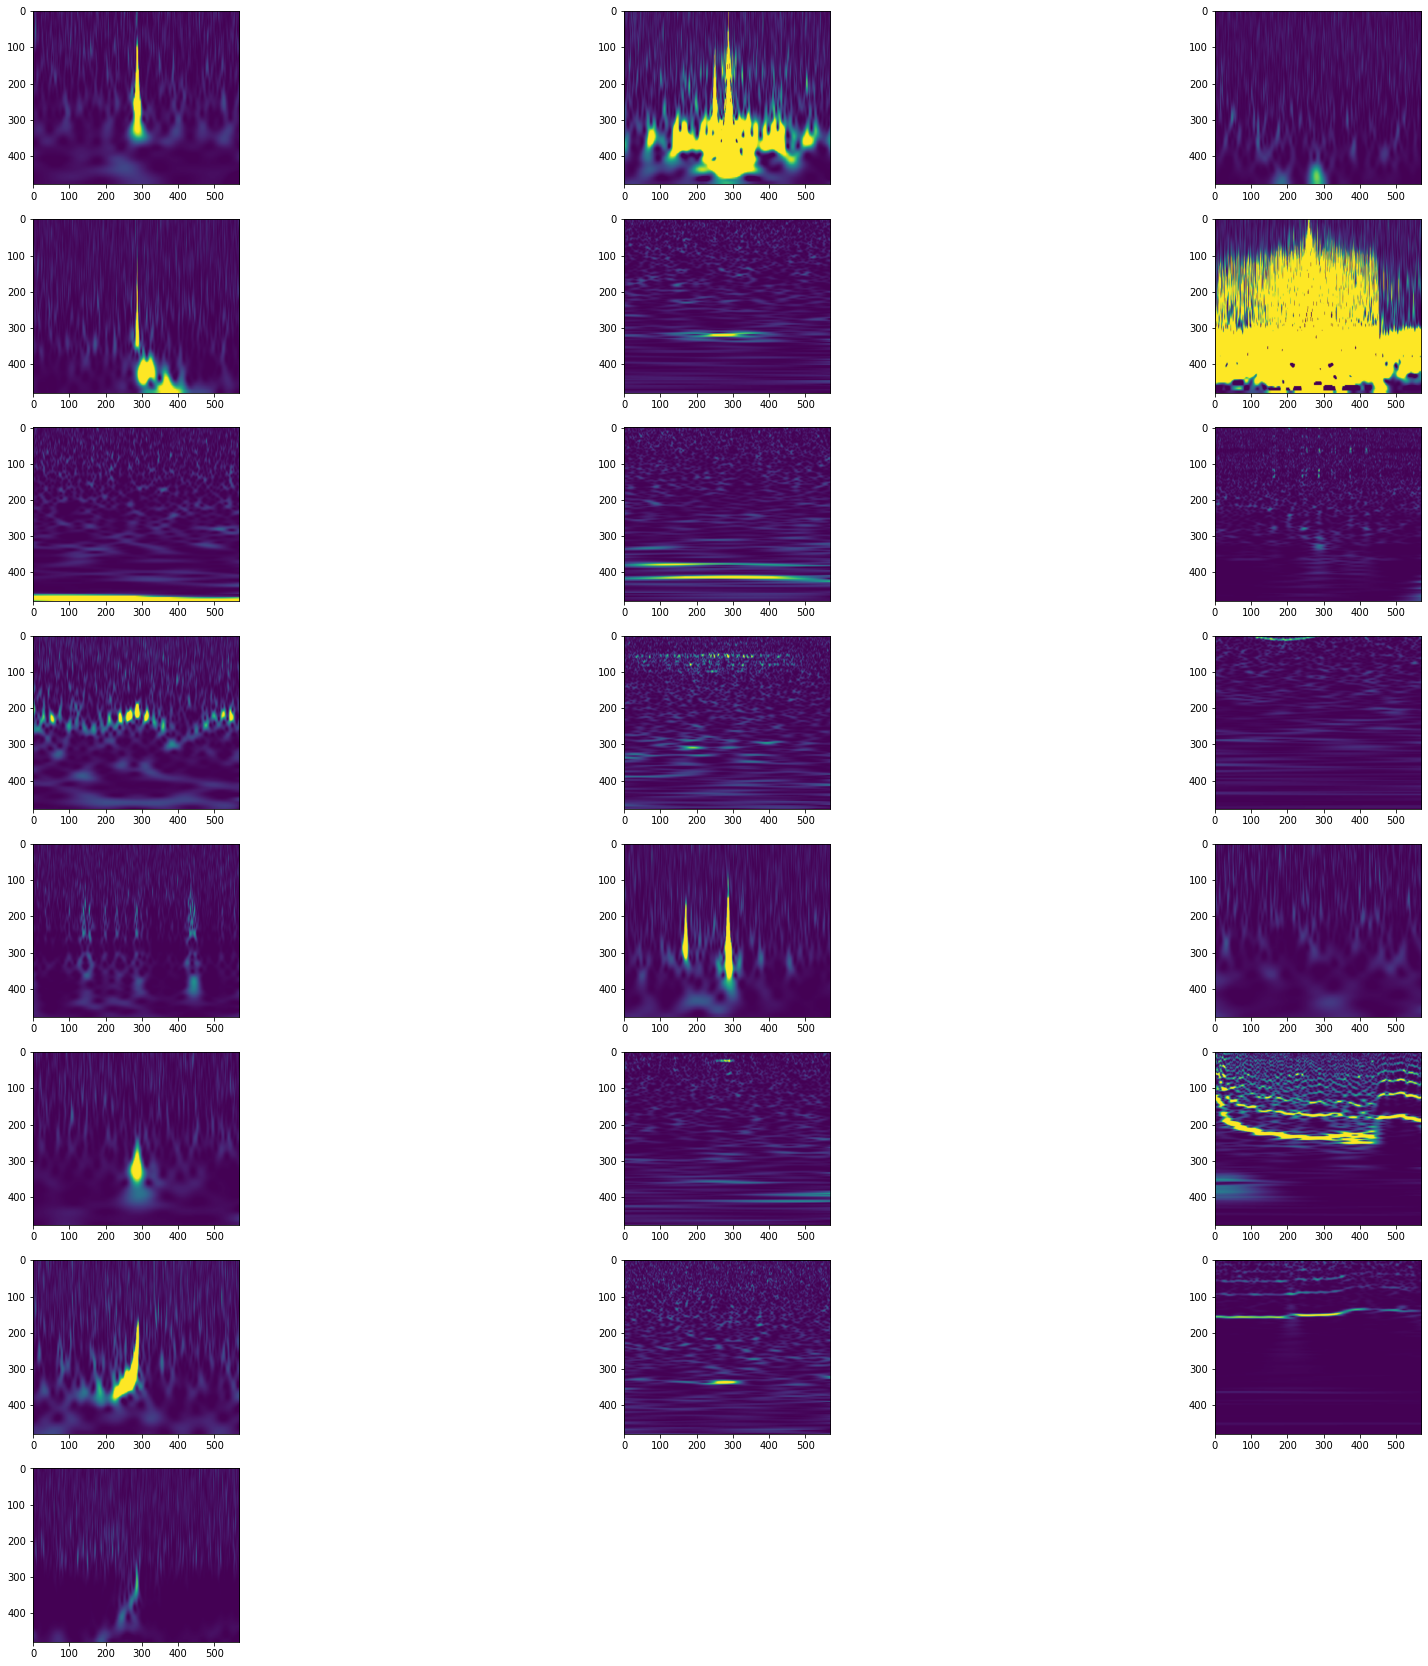

In [ ]:
plt.figure(figsize=(30, 30))
    
for i in range(0, 22):
    plt.subplot(8, 3, i+1)
    fullpath = train_dir + "/" + classes_list[i] + '/' + os.listdir(train_dir + "/" + classes_list[i])[0]
    img=mpimg.imread(fullpath)
    plt.imshow(img)

In [ ]:
training_batch_size = 10
validation_batch_size = 10
img_dim = 250

train_generator = train_datagen.flow_from_directory(
  train_dir,                                                  
  classes = classes_list,
  target_size = (img_dim, img_dim),            
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 22348 images belonging to 22 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 4800 images belonging to 22 classes.


In [ ]:
test_size = !find '/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/test/test' -type f | wc -l
test_size = int(test_size[0])
test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False)

Found 4720 images belonging to 22 classes.


In [ ]:
input_shape = (img_dim, img_dim, 3)

base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape = input_shape
)
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dense(22, activation="softmax"))

model.layers[0].trainable = False

model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = [tf.keras.metrics.AUC(name='accuracy')]
)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dense_1 (Dense)              (None, 22)                11286     
Total params: 90,716,566
Trainable params: 67,124,758
Non

In [ ]:
training_step_size = 32
validation_step_size = 32
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    mode = "max",
    patience = 6
)
history = model.fit(
    train_generator,
    steps_per_epoch = training_step_size,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = validation_step_size,
    callbacks = [early_stopping],
    verbose = 1,
)

print("Training Done")
model.save("Resnet50-Glitch.h5")

Epoch 1/100
32/32 [==============================] - 279s 8s/step - loss: 25.2920 - accuracy: 0.6061 - val_loss: 3.8148 - val_accuracy: 0.6727
Epoch 2/100
32/32 [==============================] - 229s 7s/step - loss: 3.4718 - accuracy: 0.7553 - val_loss: 2.9660 - val_accuracy: 0.7059
Epoch 3/100
32/32 [==============================] - 216s 7s/step - loss: 2.5967 - accuracy: 0.8162 - val_loss: 2.8104 - val_accuracy: 0.7476
Epoch 4/100
32/32 [==============================] - 202s 6s/step - loss: 2.0466 - accuracy: 0.8781 - val_loss: 2.6249 - val_accuracy: 0.7817
Epoch 5/100
32/32 [==============================] - 197s 6s/step - loss: 2.1530 - accuracy: 0.8681 - val_loss: 2.5389 - val_accuracy: 0.7889
Epoch 6/100
32/32 [==============================] - 191s 6s/step - loss: 2.0713 - accuracy: 0.8722 - val_loss: 2.2391 - val_accuracy: 0.8682
Epoch 7/100
32/32 [==============================] - 179s 6s/step - loss: 1.9170 - accuracy: 0.8853 - val_loss: 2.4222 - val_accuracy: 0.8231
Epoch

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


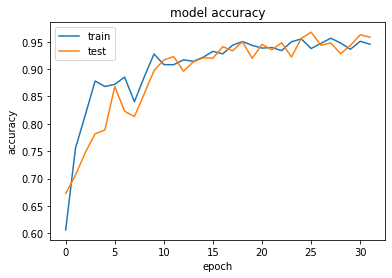

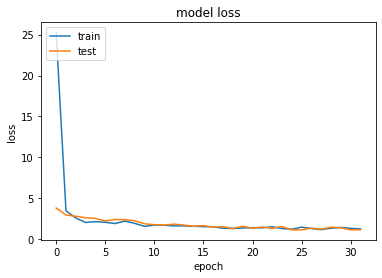

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_scores = model.evaluate(test_generator, steps = test_size, verbose = 1)

4720/4720 [==============================] - 1719s 364ms/step - loss: 1.0292 - accuracy: 0.9629


In [ ]:

print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

Testing Accuracy: 96.29%


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

classes = classes_list
train_hist = history
test_gen = test_generator

y_actual = test_generator.classes

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)

# Evaluate the results:
test_loss, test_metric = model.evaluate(test_gen,verbose = False)
results       = round(test_metric,2)*100 
results_title ="\n Model Accuracy on Test Data:{}%".format(results)
print(results_title.format(results))
print(len(results_title) * "-")
    
# print classification report
print(classification_report(y_actual, y_pred, target_names=classes))


 Model Accuracy on Test Data:96.0%
-----------------------------------
                     precision    recall  f1-score   support

               Blip       0.80      0.97      0.87      1092
           Koi_Fish       0.68      0.90      0.77       408
Low_Frequency_Burst       0.59      0.92      0.72       360
   Light_Modulation       0.96      0.14      0.25       312
         Power_Line       0.67      0.99      0.80       272
     Extremely_Loud       0.78      0.93      0.85       256
Low_Frequency_Lines       0.78      0.87      0.82       264
    Scattered_Light       0.95      0.87      0.91       268
        Violin_Mode       0.91      0.47      0.62       256
           Scratchy       0.50      0.92      0.65       200
          1080Lines       0.48      0.71      0.58       200
            Whistle       0.66      0.28      0.40       180
              Helix       0.75      0.23      0.35       168
    Repeating_Blips       0.93      0.17      0.29       148
          No

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# extract data from training history for plotting
history_dict    = train_hist.history
loss_values     = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values      = history_dict['accuracy']
val_accuracy_values  = history_dict['val_accuracy']
epochs          = range(1, len(history_dict['accuracy']) + 1)

# get the min loss and max accuracy for plotting
max_acc = np.max(val_accuracy_values)
min_loss = np.min(val_loss_values)
    

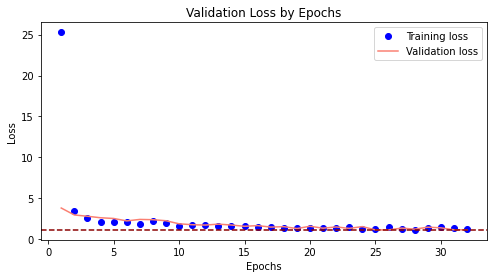

In [ ]:
# create plots
plt.subplots(figsize=(8,4))

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'salmon', label = 'Validation loss')
plt.title('Validation Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axhline(y=min_loss,color='darkred', linestyle='--')
plt.legend()

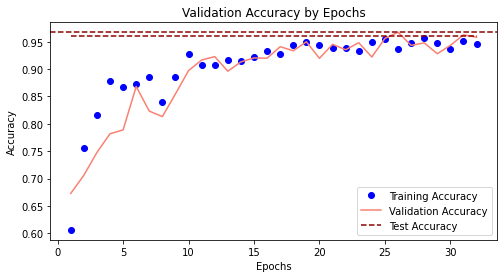

In [ ]:
plt.subplots(figsize=(8,4))
plt.plot(epochs, acc_values, 'bo',label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'salmon', label = 'Validation Accuracy')
plt.plot(epochs,[results/100]*len(epochs),'darkred',linestyle = '--',label='Test Accuracy')
plt.title('Validation Accuracy by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.axhline(y=max_acc,color='darkred', linestyle='--')
plt.legend()

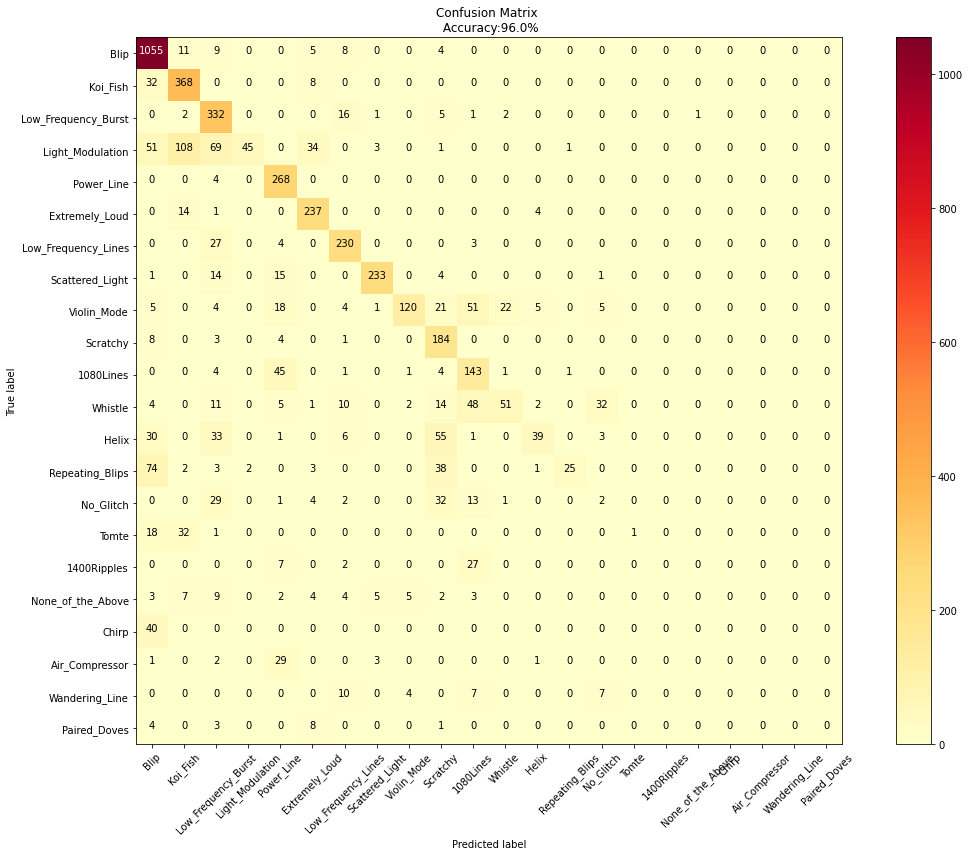

In [ ]:
# calculate Confusion Matrix
cm = confusion_matrix(y_actual, y_pred)

# create confusion matrix plot
plt.subplots(figsize=(16,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.YlOrRd)
plt.title("Confusion Matrix \n Accuracy:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(c, r, format(cm[r, c], 'd'),
              horizontalalignment="center",
              color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

def plot_training_metrics(train_hist,model,test_gen,y_actual,y_pred,classes):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    
    # Evaluate the results:
    test_loss, test_metric = model.evaluate(test_gen,verbose = False)
    results       = round(test_metric,2)*100 
    results_title ="\n Model Accuracy on Test Data:{}%".format(results)
    print(results_title.format(results))
    print(len(results_title) * "-")
    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values      = history_dict['accuracy']
    val_accuracy_values  = history_dict['val_accuracy']
    epochs          = range(1, len(history_dict['accuracy']) + 1)

    # get the min loss and max accuracy for plotting
    max_acc = np.max(val_accuracy_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(36,12))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'salmon', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkred', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, acc_values, 'bo',label = 'Training Accuracy')
    plt.plot(epochs, val_accuracy_values, 'salmon', label = 'Validation Accuracy')
    plt.plot(epochs,[results/100]*len(epochs),'darkred',linestyle = '--',label='Test Accuracy')
    plt.title('Validation accuracy by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.axhline(y=max_acc,color='darkred', linestyle='--')
    plt.legend()

    
    # calculate Confusion Matrix
    cm = confusion_matrix(y_actual, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.YlOrRd)
    plt.title("Confusion Matrix \n Accuracy:{}%".format(results))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


 Model Accuracy on Test Data:96.0%
-----------------------------------
                     precision    recall  f1-score   support

               Blip       0.80      0.97      0.87      1092
           Koi_Fish       0.68      0.90      0.77       408
Low_Frequency_Burst       0.59      0.92      0.72       360
   Light_Modulation       0.96      0.14      0.25       312
         Power_Line       0.67      0.99      0.80       272
     Extremely_Loud       0.78      0.93      0.85       256
Low_Frequency_Lines       0.78      0.87      0.82       264
    Scattered_Light       0.95      0.87      0.91       268
        Violin_Mode       0.91      0.47      0.62       256
           Scratchy       0.50      0.92      0.65       200
          1080Lines       0.48      0.71      0.58       200
            Whistle       0.66      0.28      0.40       180
              Helix       0.75      0.23      0.35       168
    Repeating_Blips       0.93      0.17      0.29       148
          No

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


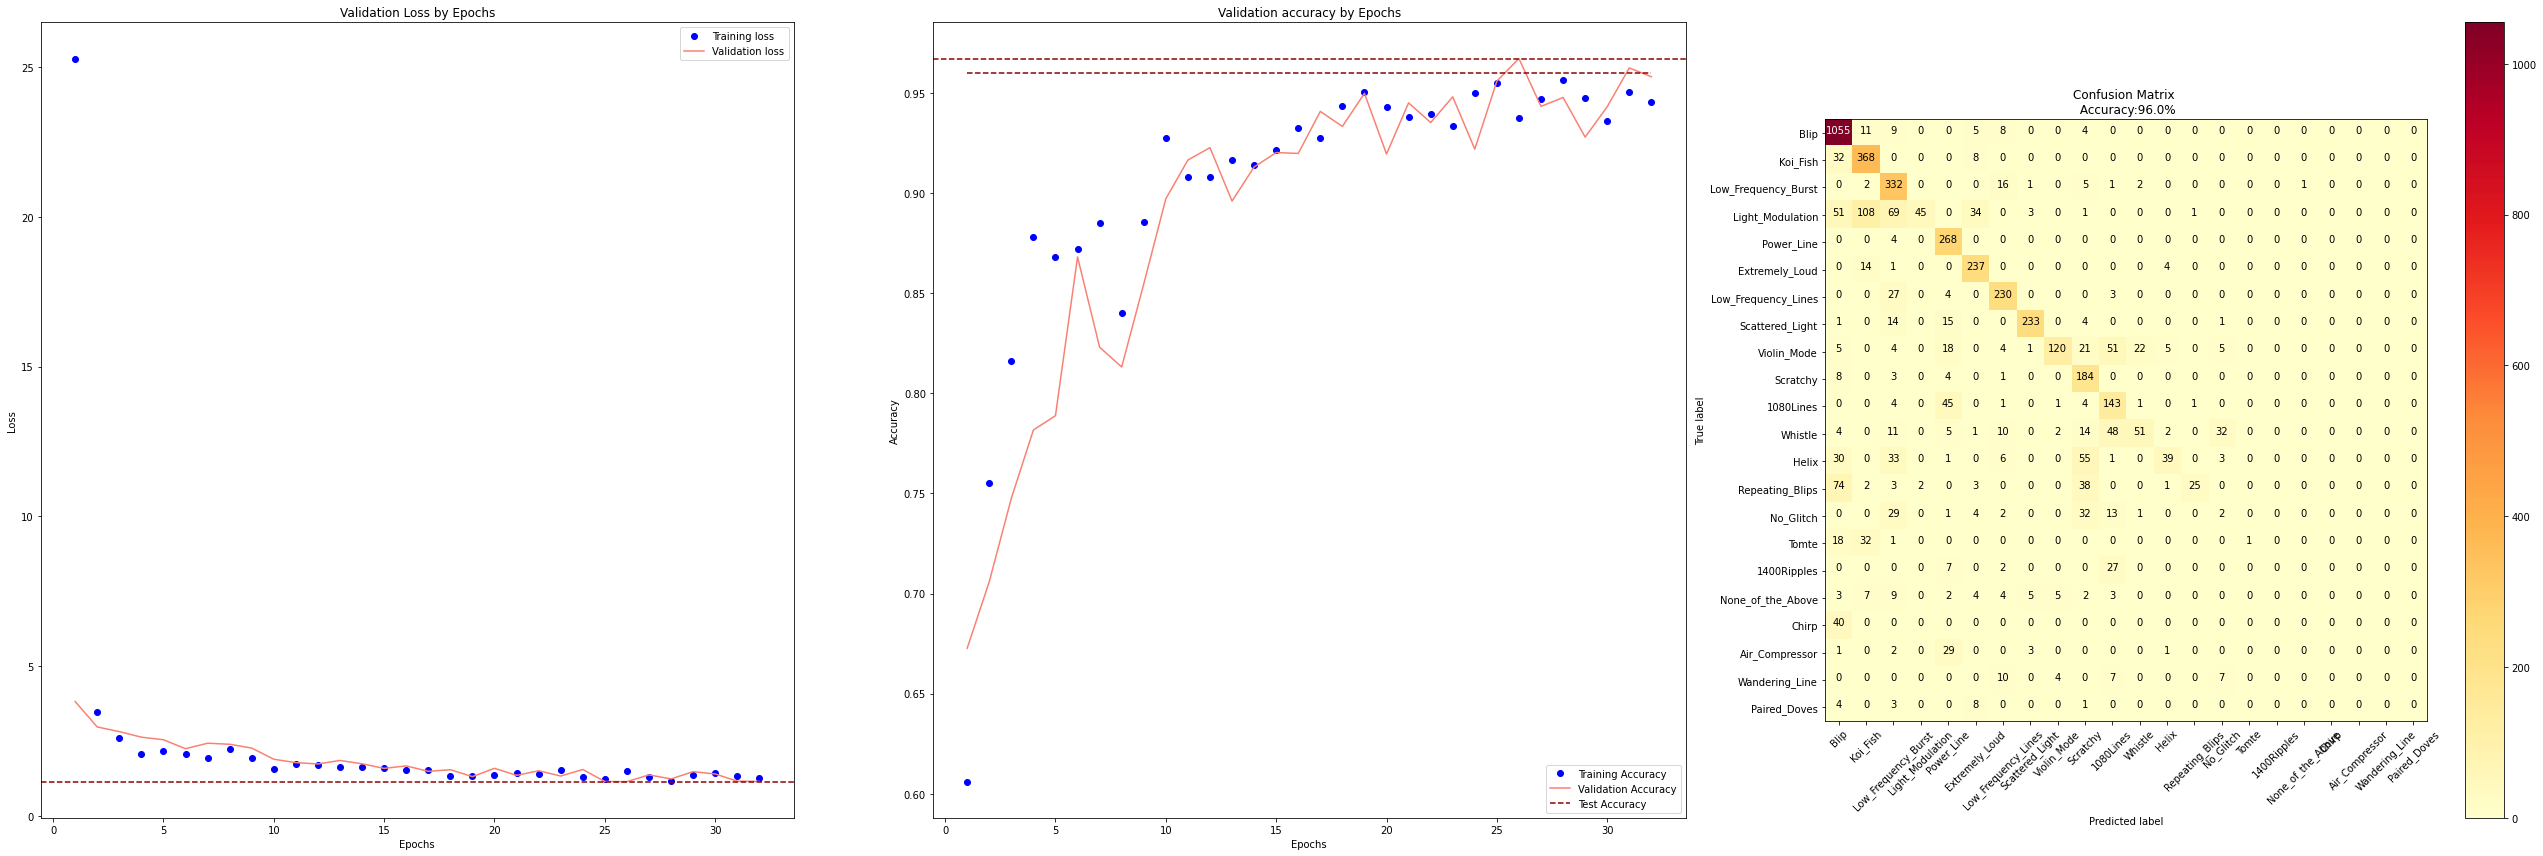

In [ ]:
y_actual = test_generator.classes

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)



plot_training_metrics(history, model, test_generator, y_actual, y_pred, classes_list )

In [ ]:
y_actual

In [ ]:
df = pd.DataFrame(predictions)
df['filename'] = test_generator.filenames
df['truth'] = ''
df['truth'] = df['filename'].str.split('/', 1, expand = True)
df['prediction_index'] = df[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]].idxmax(axis=1)

df['prediction'] = ''

for i in range(0,22):
    df['prediction'][df['prediction_index'] == i] = classes_list[i]
    
cm = confusion_matrix(df['truth'], df['prediction'])

cm_df = pd.DataFrame(cm)

cm_df.columns = classes_list
cm_df['signal'] = classes_list

cm_df

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 12))

corr = cm_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.color_palette("Greens"),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
accuracy = accuracy_score(df['truth'], df['prediction'])
accuracy